# Analysis of NIST Ground dataset (Executable without Solar Data Tools)

This notebook is a short version using PVPRO to analyze the NIST dataset. The full version is in 'NIST_ground_array_analyze_detailed'.

It can be run without Solar Data Tools.

The NIST dataset is publicly available here: https://pvdata.nist.gov/




In [2]:
import pandas as pd
import numpy as np
from pvlib.pvsystem import retrieve_sam
from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.plotting import plot_results_timeseries

## Load data

In [3]:
# Require the download of NIST-ground dataset from:
# https://datahub.duramat.org/dataset/nist_ground_array_dataset
dfi = pd.read_pickle('../examples/data/nist01_onemin-Ground.pkl')
df_pvpro = dfi[::20] # downsample to 20 min

In [4]:
# Meta information of PV module
modules_per_string = 12
parallel_strings = 96
voltage_dc_key = 'InvVDCin_Avg'
current_dc_key = 'InvIDCin_Avg'
temperature_module_key= 'RTD_C_Avg_4'
irradiance_poa_key = 'RefCell1_Wm2_Avg'
cells_in_series = 60
alpha_isc = 0.053e-2*8.6 # units of A/C
delta_T = 3
technology = 'mono-Si'
module = retrieve_sam('CECmod')['Sharp_NU_U235F2']

## Preprocess data

In [5]:
pre = Preprocessor(voltage_dc_key = voltage_dc_key,
                   current_dc_key = current_dc_key,
                   temperature_module_key = temperature_module_key,
                   irradiance_poa_key = irradiance_poa_key,
                   modules_per_string = modules_per_string,
                   parallel_strings = parallel_strings,
                   techonology = technology,
                   alpha_isc = alpha_isc,
                   cells_in_series = cells_in_series,
                   ignore_warning=True
                   )

df_pvpro = pre.run_basic_preprocess(df_pvpro, use_sdt = False)
df_pvpro['current_irradiance_outliers'], filter_IG_info = pre.find_current_irradiance_outliers(
                                                    df_pvpro, points_per_iteration=1000)
df_pvpro['voltage_temperature_outliers'], filter_VT_info= pre.find_temperature_voltage_outliers(df_pvpro, 
                                                  voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=1000) 

## Parameter extraction

In [6]:
pvp = PvProHandler(df=df_pvpro,
                   voltage_key=voltage_dc_key,
                   current_key=current_dc_key,
                   irradiance_poa_key=irradiance_poa_key,
                   temperature_cell_key='temperature_cell',
                   alpha_isc=alpha_isc,
                   cells_in_series=cells_in_series,
                   modules_per_string=modules_per_string,
                   parallel_strings=parallel_strings,
                   resistance_shunt_ref=module['R_sh_ref'],
                   technology=technology,
                   days_per_run = 14
                  )

# Run pipeline to get the SDM parameters
pfit = pvp.run_pipeline()

100%|██████████| 104/104 [00:04<00:00, 20.96it/s]

Elapsed time: 0.08 min


## Plot degradation trend of parameters

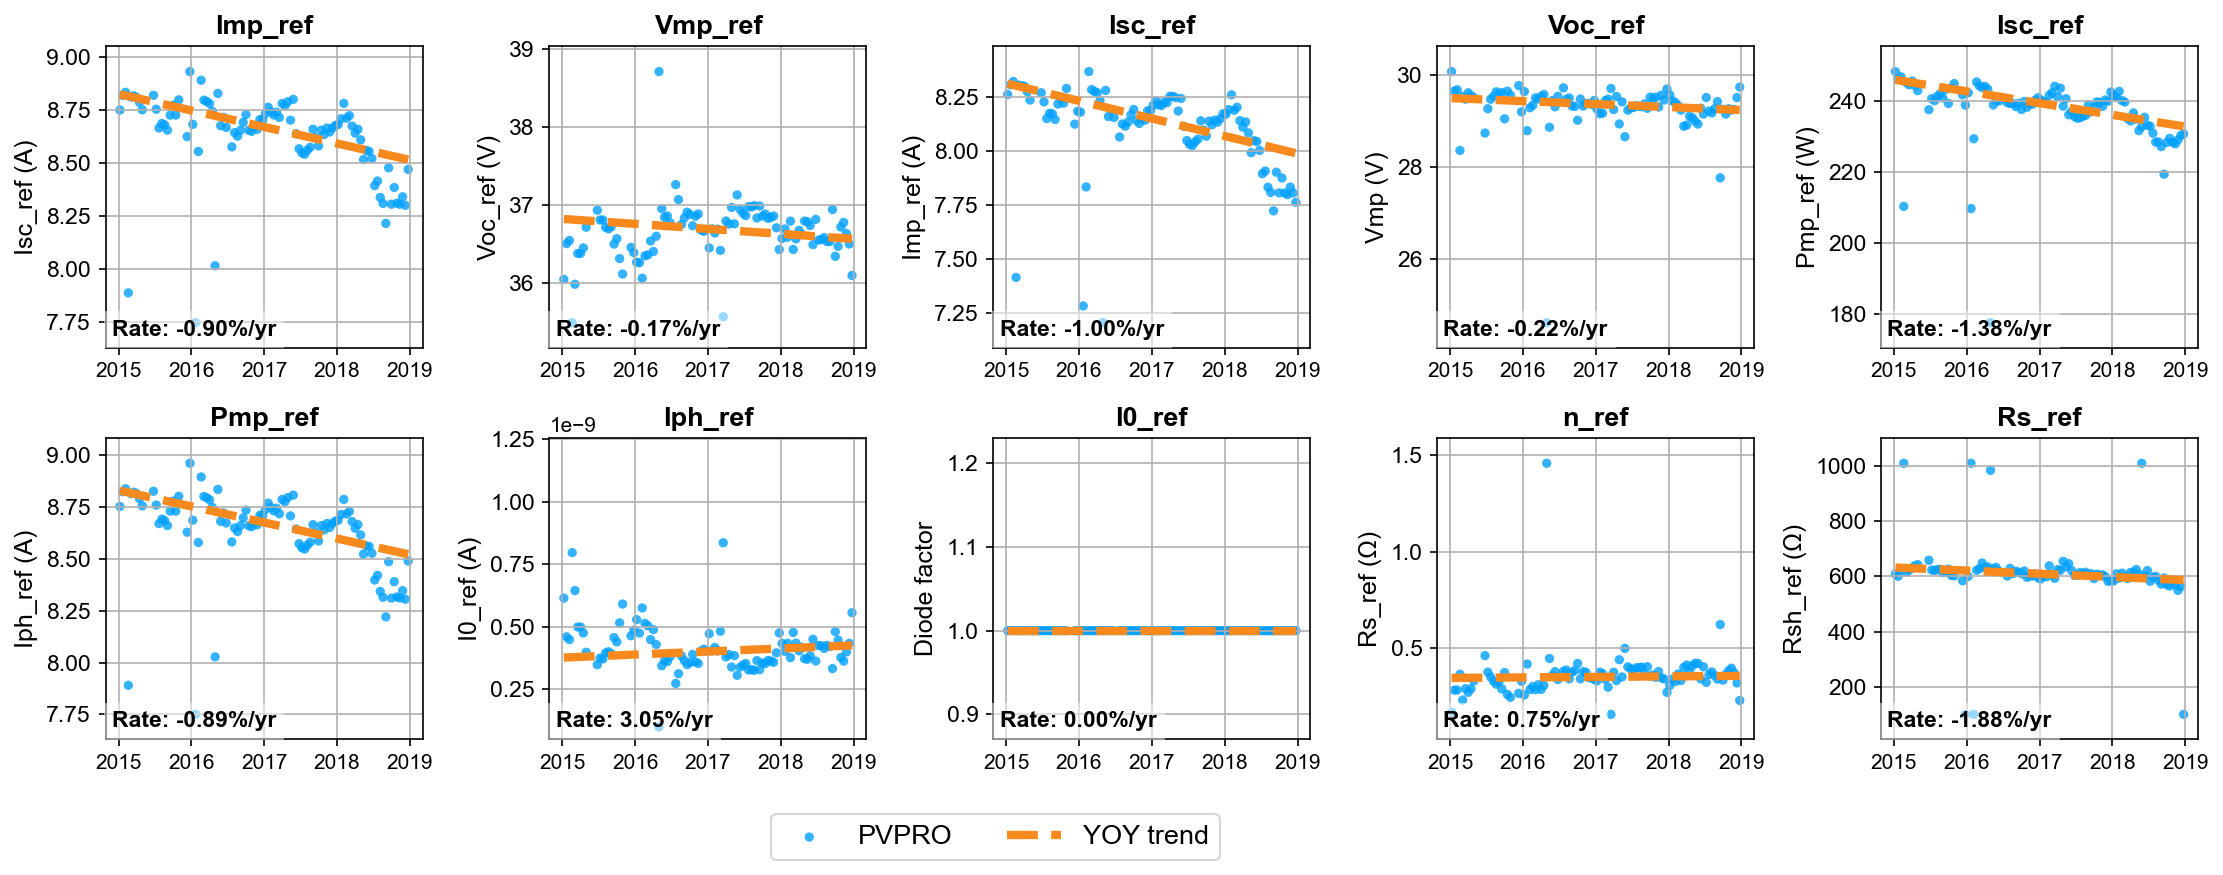

In [7]:
# Calculate year-of-year (YOY) trend
yoy_result = pvp.analyze_yoy(pfit)

# Plot the evolution of extracted parameters
plot_results_timeseries(pfit, yoy_result = yoy_result)